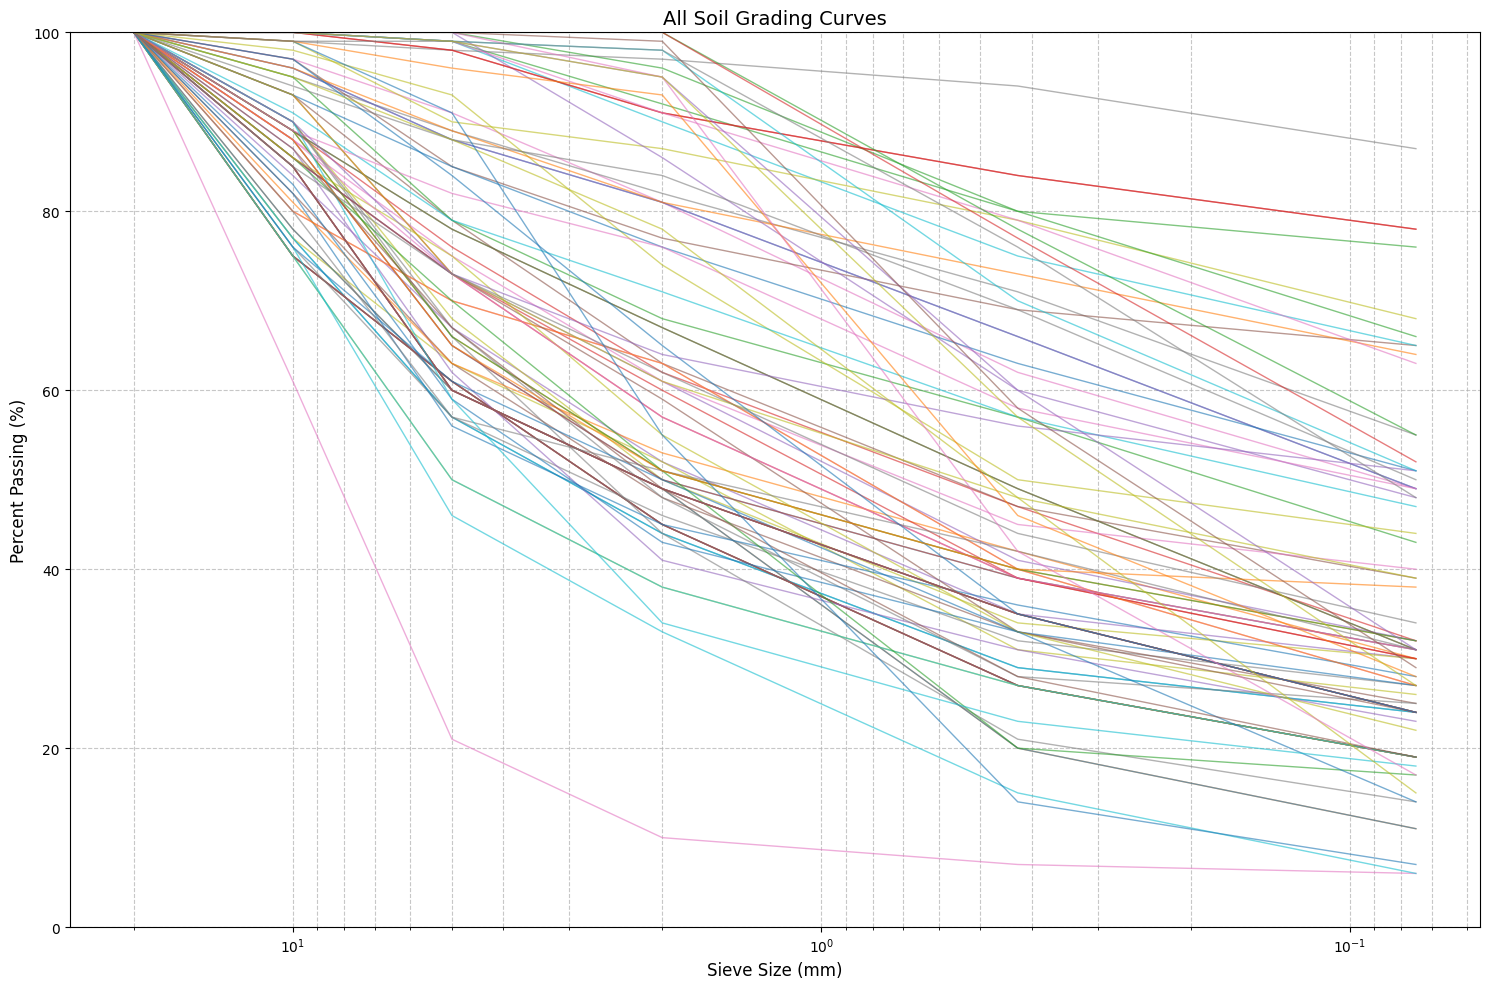

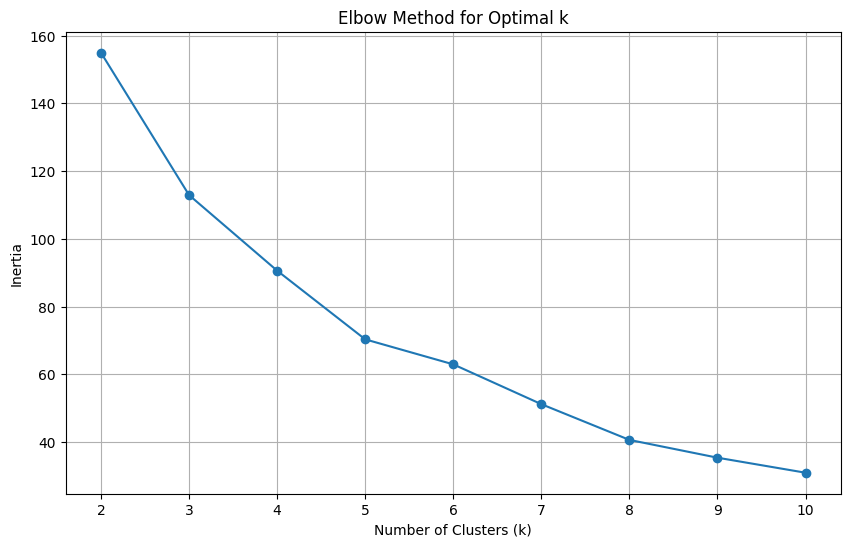

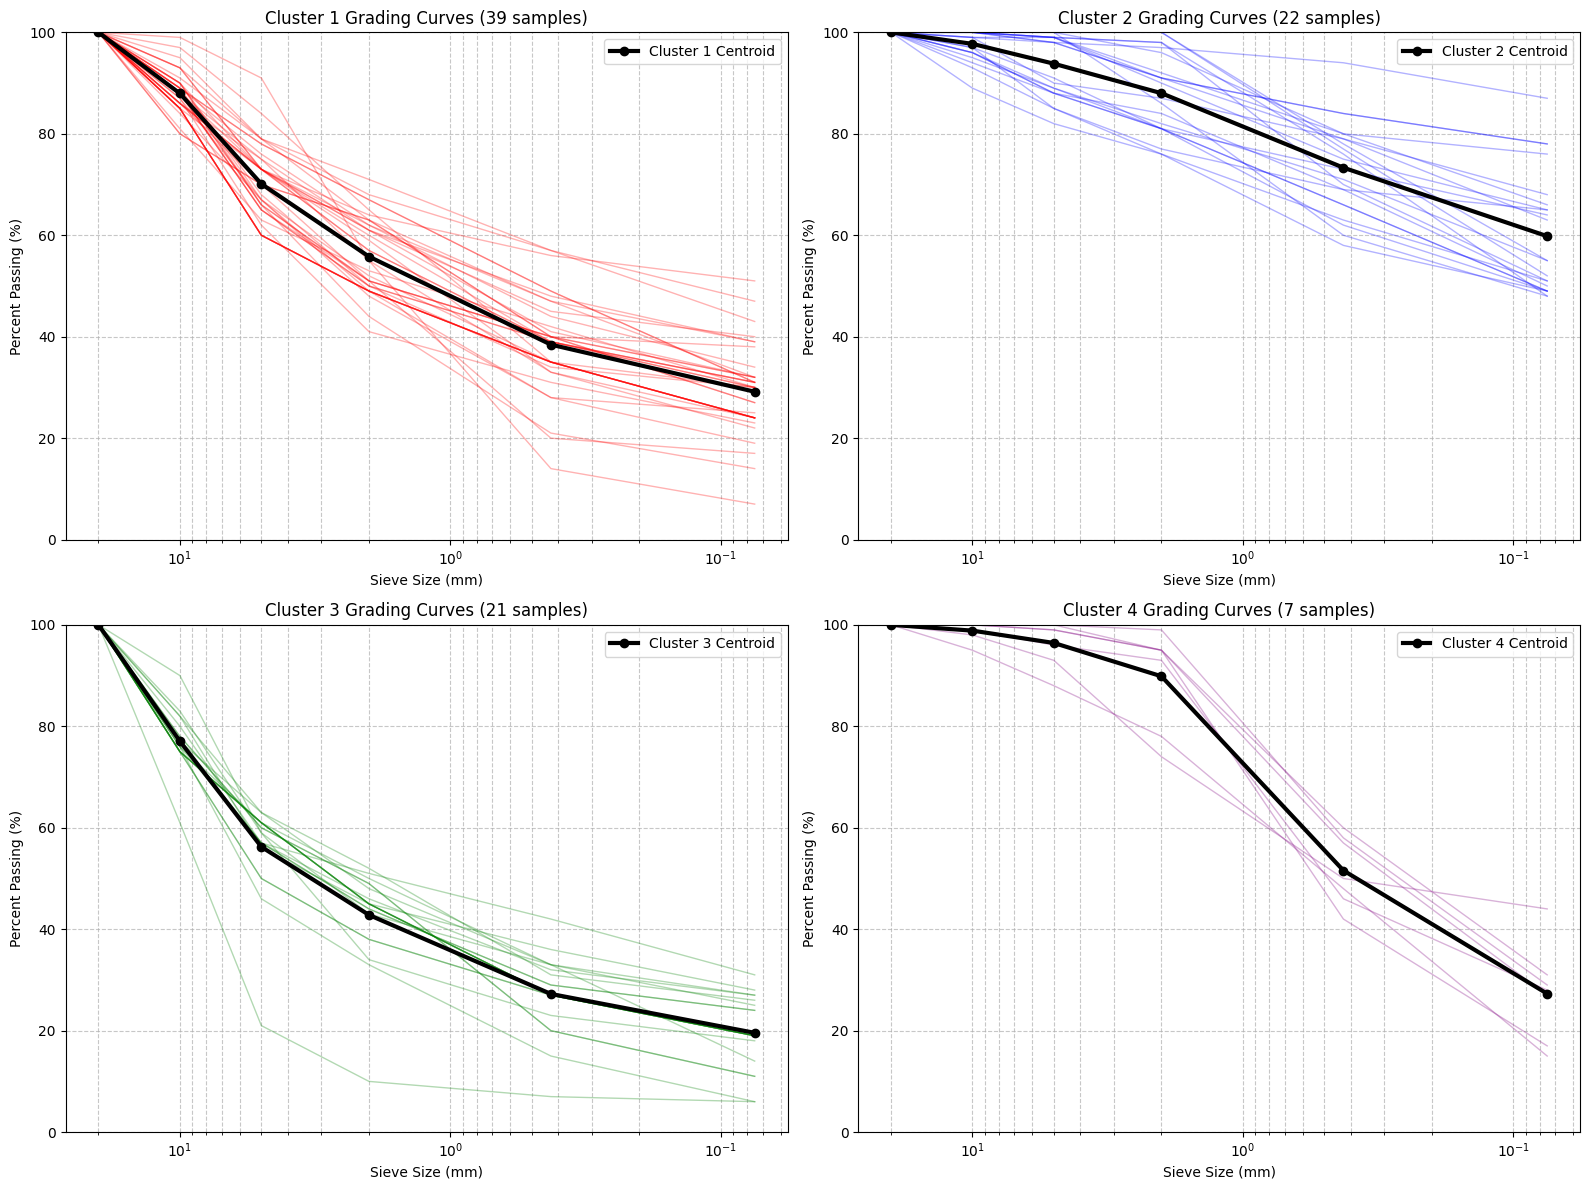

=== GRADING CLUSTER ANALYSIS ===

Cluster 1:
  Number of samples: 39
  Sample numbers: [ 4  5  6 17 19 20 22 23 24 25 27 28 32 33 34 35 37 38 42 43 44 46 50 53
 56 59 62 63 64 65 66 67 69 71 72 75 76 78 81]
  Average % passing through sieves:
    20mm: 100.0%
    10mm: 87.9%
    5mm: 70.1%
    2mm: 55.8%
    0.425mm: 38.4%
    0.075mm: 29.2%

Cluster 2:
  Number of samples: 22
  Sample numbers: [ 3  7  8 21 36 40 45 48 49 51 52 54 55 57 58 73 74 77 80 83 84 88]
  Average % passing through sieves:
    20mm: 100.0%
    10mm: 97.7%
    5mm: 93.8%
    2mm: 88.0%
    0.425mm: 73.3%
    0.075mm: 59.8%

Cluster 3:
  Number of samples: 21
  Sample numbers: [ 1  2  9 10 11 12 13 14 15 16 18 26 29 30 31 41 47 60 61 68 70]
  Average % passing through sieves:
    20mm: 100.0%
    10mm: 77.0%
    5mm: 56.2%
    2mm: 42.8%
    0.425mm: 27.2%
    0.075mm: 19.6%

Cluster 4:
  Number of samples: 7
  Sample numbers: [39 79 82 85 86 87 89]
  Average % passing through sieves:
    20mm: 100.0%
    10mm: 98

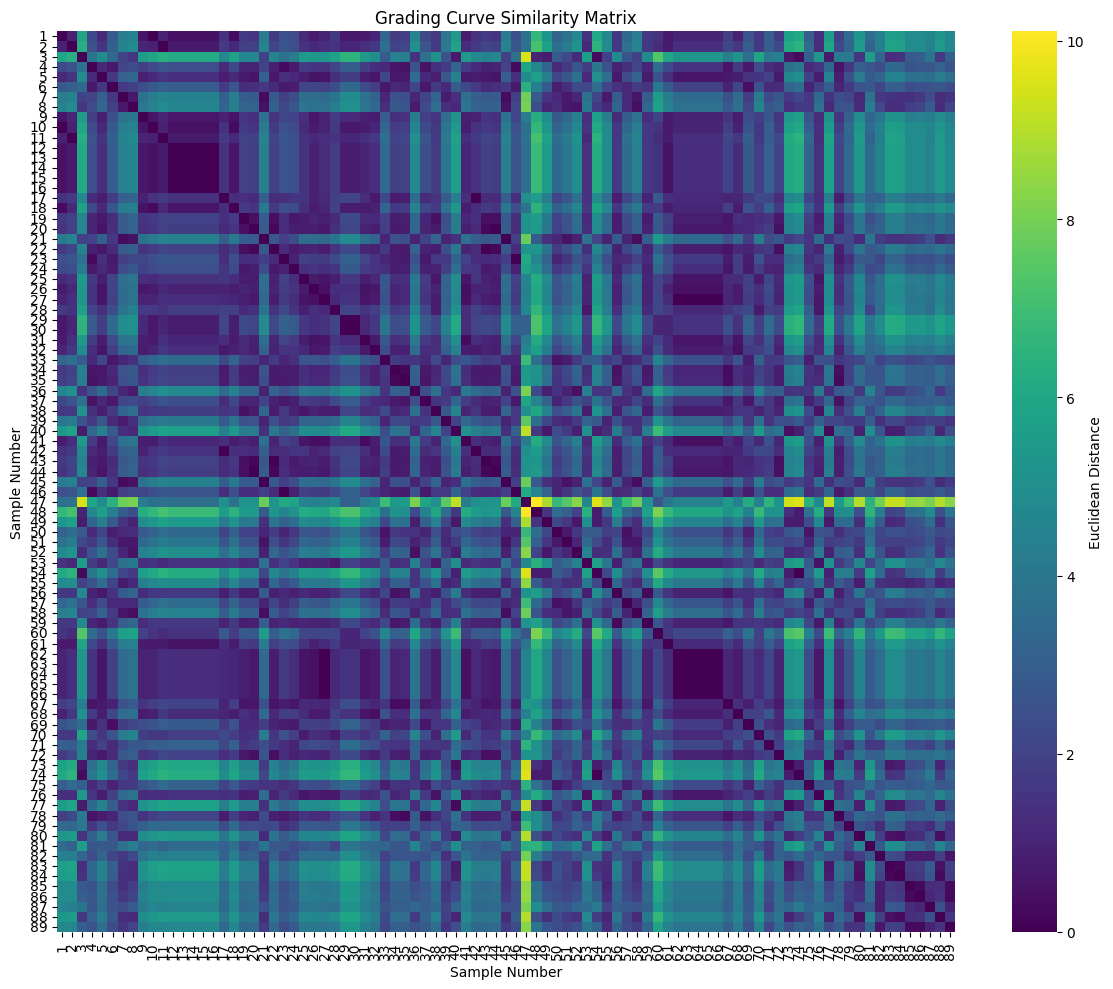


=== REPRESENTATIVE SAMPLES ===
Cluster 1 representative: Sample 67
Cluster 2 representative: Sample 40
Cluster 3 representative: Sample 1
Cluster 4 representative: Sample 82


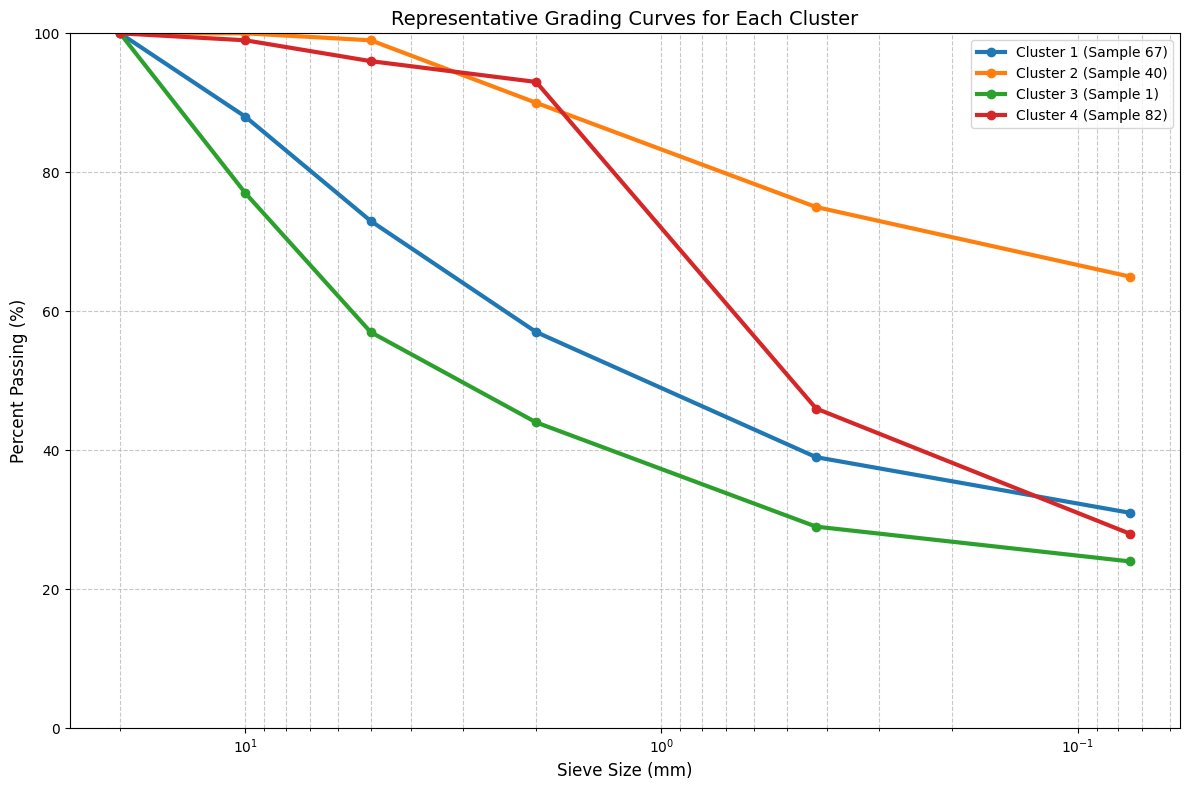


Results saved to 'soil_grading_clusters.csv'
Generated 4 clusters based on grading curve similarity


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv(r'C:\Users\User\Desktop\machine_learning\soils\cleaned_MTRD_Soils_data.csv')

# Extract grading data
grading_cols = [col for col in df.columns if 'Grading.%PassingBSSieveSize' in col]
sieve_sizes = [20, 10, 5, 2, 0.425, 0.075]  # mm
sample_numbers = df['SampleNo.'].values

# Create grading matrix
grading_data = df[grading_cols].values

# 1. PLOT ALL GRADING CURVES
plt.figure(figsize=(15, 10))
for i, sample in enumerate(sample_numbers):
    plt.semilogx(sieve_sizes, grading_data[i], alpha=0.6, linewidth=1)

plt.xlabel('Sieve Size (mm)', fontsize=12)
plt.ylabel('Percent Passing (%)', fontsize=12)
plt.title('All Soil Grading Curves', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('all_grading_curves.png', dpi=300)
plt.show()

# 2. CLUSTER ANALYSIS BASED ON GRADING CURVES
# Standardize the grading data for clustering
scaler = StandardScaler()
grading_scaled = scaler.fit_transform(grading_data)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(grading_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Use 4 clusters (you can adjust based on elbow plot)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(grading_scaled)

# Add cluster labels to dataframe
df['GradingCluster'] = clusters

# 3. PLOT GRADING CURVES BY CLUSTER
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    
    # Plot individual curves for this cluster
    for idx in cluster_indices:
        axes[cluster].semilogx(sieve_sizes, grading_data[idx], 
                              color=colors[cluster], alpha=0.3, linewidth=1)
    
    # Plot cluster centroid
    centroid = kmeans.cluster_centers_[cluster]
    centroid_original = scaler.inverse_transform(centroid.reshape(1, -1))[0]
    axes[cluster].semilogx(sieve_sizes, centroid_original, 
                          color='black', linewidth=3, marker='o', 
                          label=f'Cluster {cluster+1} Centroid')
    
    axes[cluster].set_xlabel('Sieve Size (mm)')
    axes[cluster].set_ylabel('Percent Passing (%)')
    axes[cluster].set_title(f'Cluster {cluster+1} Grading Curves ({len(cluster_indices)} samples)')
    axes[cluster].grid(True, which='both', linestyle='--', alpha=0.7)
    axes[cluster].invert_xaxis()
    axes[cluster].set_ylim(0, 100)
    axes[cluster].legend()

plt.tight_layout()
plt.savefig('grading_curves_by_cluster.png', dpi=300)
plt.show()

# 4. STATISTICAL SUMMARY BY CLUSTER
print("=== GRADING CLUSTER ANALYSIS ===")
for cluster in range(n_clusters):
    cluster_samples = df[df['GradingCluster'] == cluster]['SampleNo.'].values
    print(f"\nCluster {cluster+1}:")
    print(f"  Number of samples: {len(cluster_samples)}")
    print(f"  Sample numbers: {cluster_samples}")
    
    # Calculate average grading for this cluster
    cluster_data = grading_data[clusters == cluster]
    avg_grading = np.mean(cluster_data, axis=0)
    
    print("  Average % passing through sieves:")
    for i, size in enumerate(sieve_sizes):
        print(f"    {size}mm: {avg_grading[i]:.1f}%")

# 5. CREATE SIMILARITY MATRIX
# Calculate pairwise distances between grading curves
distances = pdist(grading_scaled, metric='euclidean')
distance_matrix = squareform(distances)

# Plot similarity heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, 
            xticklabels=sample_numbers, 
            yticklabels=sample_numbers,
            cmap='viridis', 
            cbar_kws={'label': 'Euclidean Distance'})
plt.title('Grading Curve Similarity Matrix')
plt.xlabel('Sample Number')
plt.ylabel('Sample Number')
plt.tight_layout()
plt.savefig('grading_similarity_matrix.png', dpi=300)
plt.show()

# 6. REPRESENTATIVE SAMPLES FROM EACH CLUSTER
print("\n=== REPRESENTATIVE SAMPLES ===")
representative_samples = []
for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    
    # Find sample closest to centroid
    centroid = kmeans.cluster_centers_[cluster]
    distances_to_centroid = np.linalg.norm(grading_scaled[cluster_indices] - centroid, axis=1)
    closest_idx = cluster_indices[np.argmin(distances_to_centroid)]
    
    representative_samples.append({
        'cluster': cluster + 1,
        'sample_no': sample_numbers[closest_idx],
        'grading': grading_data[closest_idx]
    })
    
    print(f"Cluster {cluster+1} representative: Sample {sample_numbers[closest_idx]}")

# 7. PLOT REPRESENTATIVE GRADING CURVES
plt.figure(figsize=(12, 8))
for rep in representative_samples:
    plt.semilogx(sieve_sizes, rep['grading'], 
                marker='o', linewidth=3, 
                label=f"Cluster {rep['cluster']} (Sample {rep['sample_no']})")

plt.xlabel('Sieve Size (mm)', fontsize=12)
plt.ylabel('Percent Passing (%)', fontsize=12)
plt.title('Representative Grading Curves for Each Cluster', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.gca().invert_xaxis()
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('representative_grading_curves.png', dpi=300)
plt.show()

# 8. SAVE RESULTS
results_df = df[['SampleNo.', 'GradingCluster'] + grading_cols].copy()
results_df.to_csv('soil_grading_clusters.csv', index=False)

print(f"\nResults saved to 'soil_grading_clusters.csv'")
print(f"Generated {n_clusters} clusters based on grading curve similarity")